# Семинар 2

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

data = sm.datasets.macrodata.load_pandas().data

#Преобразуем данные из колонок в индекс. В данном случае проще всего было сгенерировать самим последовательность кварталов, чтобы не мучаться с конвертацией столбцов
data.index = pd.date_range(start = '01.01.1959', periods = len(data), freq='Q')
display(data)
data = data.drop(columns = ['year', 'quarter'])

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-30,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-12-31,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-03-31,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-06-30,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


## STL-декомпозиция

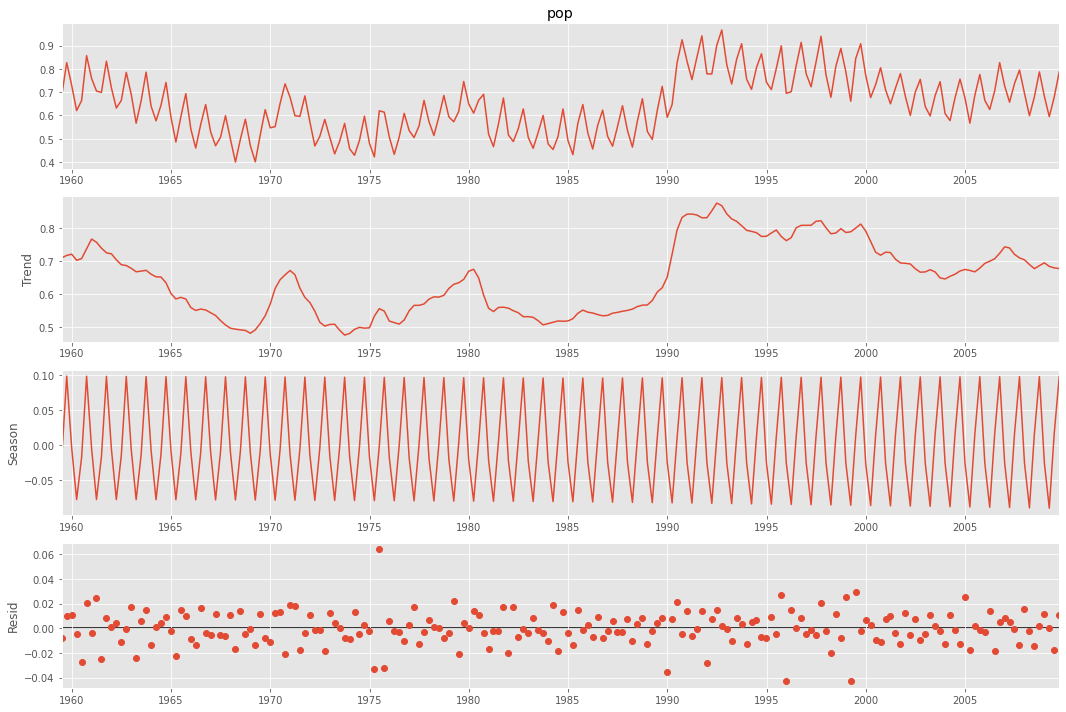

In [15]:
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(data.loc[:,'pop'].diff().dropna(), trend=5, seasonal=61)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)



(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='pop'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

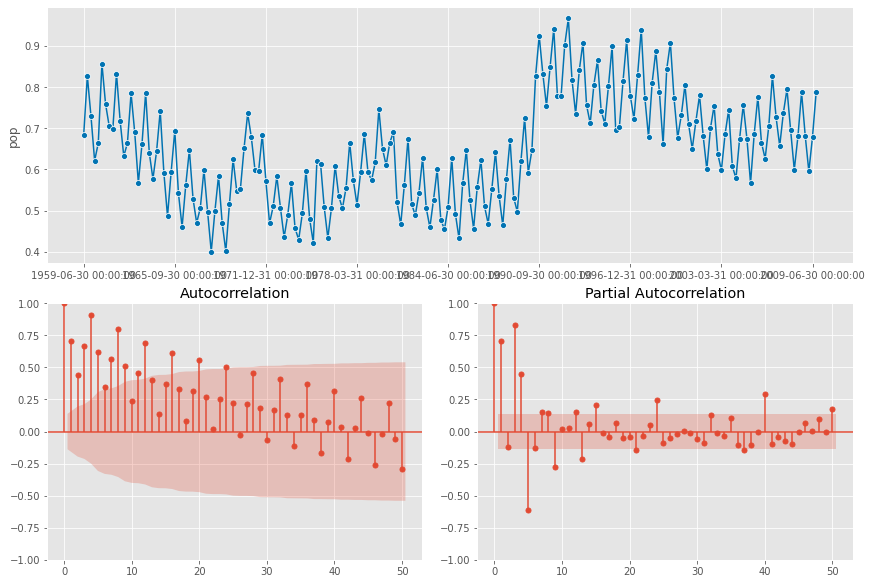

In [7]:
from sktime.utils.plotting import plot_correlations
plot_correlations(data.loc[:,'pop'].diff().dropna(), lags = 50 )

<AxesSubplot:>

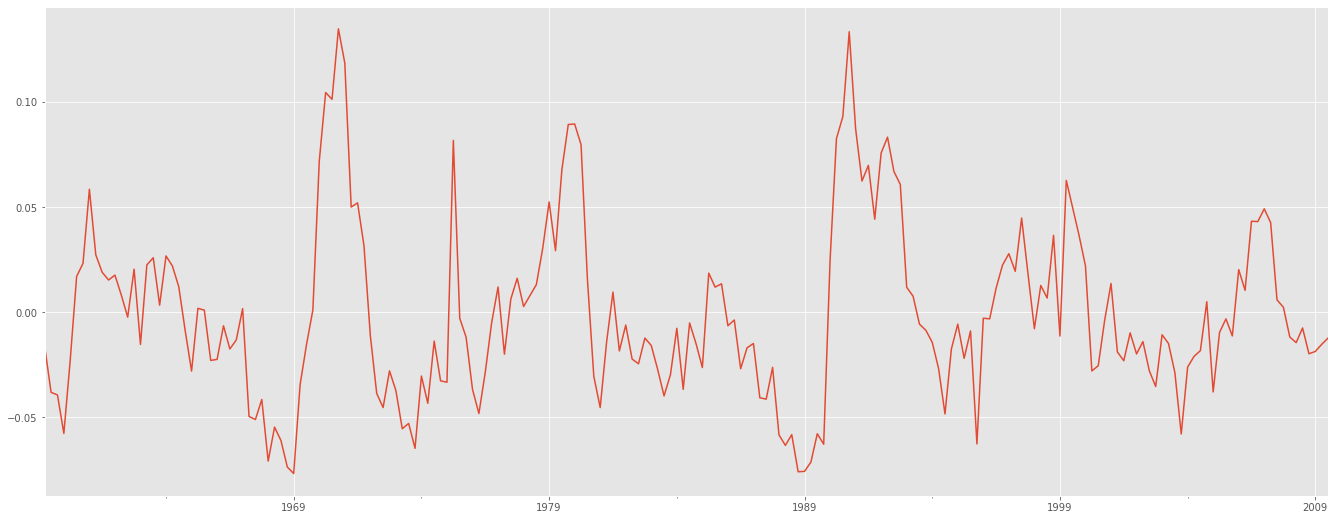

In [12]:
res.resid.plot()

In [16]:
res.seasonal

1959-06-30   -0.018367
1959-09-30    0.098806
1959-12-31   -0.003662
1960-03-31   -0.077312
1960-06-30   -0.017238
                ...   
2008-09-30    0.098019
2008-12-31   -0.025229
2009-03-31   -0.089589
2009-06-30    0.016816
2009-09-30    0.098066
Freq: Q-DEC, Name: season, Length: 202, dtype: float64

In [17]:
res.trend

1959-06-30    0.710584
1959-09-30    0.717847
1959-12-31    0.721548
1960-03-31    0.703258
1960-06-30    0.708207
                ...   
2008-09-30    0.686898
2008-12-31    0.695522
2009-03-31    0.684656
2009-06-30    0.680147
2009-09-30    0.678152
Freq: Q-DEC, Name: trend, Length: 202, dtype: float64

In [18]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_observed',
 '_resid',
 '_seasonal',
 '_trend',
 '_weights',
 'nobs',
 'observed',
 'plot',
 'resid',
 'seasonal',
 'trend',
 'weights']

## Обработка пропусков

Обработка пропусков во временных рядах связана всё с той же проблемой: данные связаны по времени. Это с одной стороны помогает, а с другой стороны мешает. Разберём некоторые наиболее значимые кейсы.

#### Смотрим на контекст!

Часто само происхождение данных или непосредственно задача диктует правила обработки пропусков. Рассмотрим пример ниже. Вам представлен график недельных цен на некоторый вид химического сырья в некотором регионе мира. В данном случае вполне логично интерпретировать пропуски как "цена не изменилась", поэтому можно заполнить пропуски просто последним доступным значением. С одной стороны это, конечно, снижает дисперсию данных, но при этом он обоснован.

In [19]:
flat = pd.read_csv('data/sem_2/weekly_flat.csv', index_col=0)
flat.index = pd.to_datetime(flat.index)

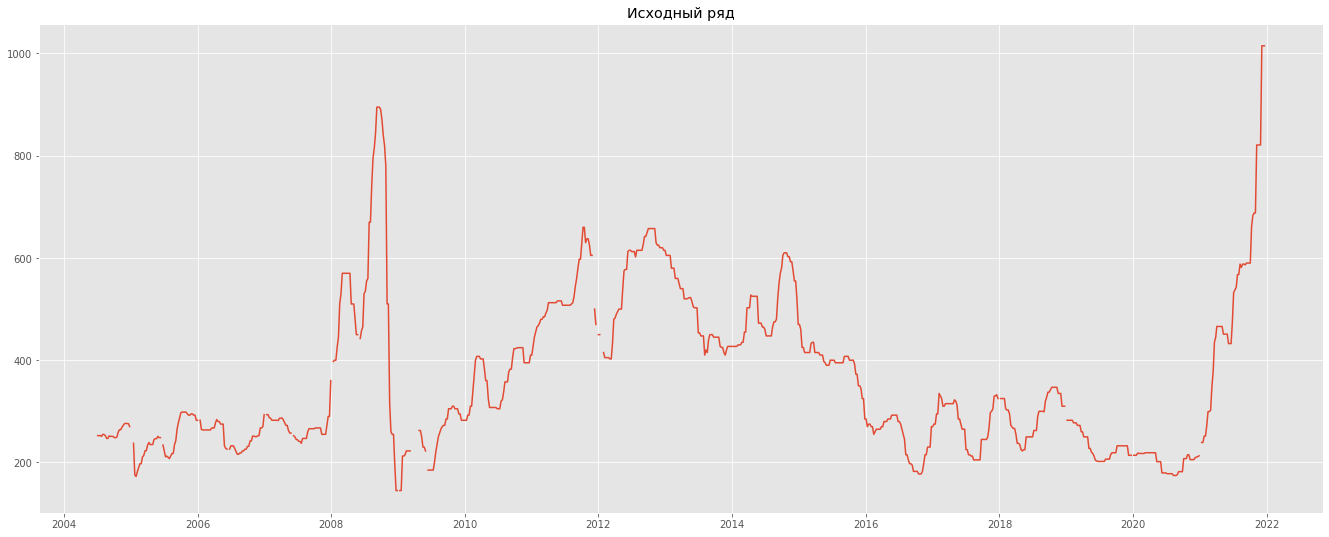

In [20]:

plt.plot(flat)
plt.title('Исходный ряд');

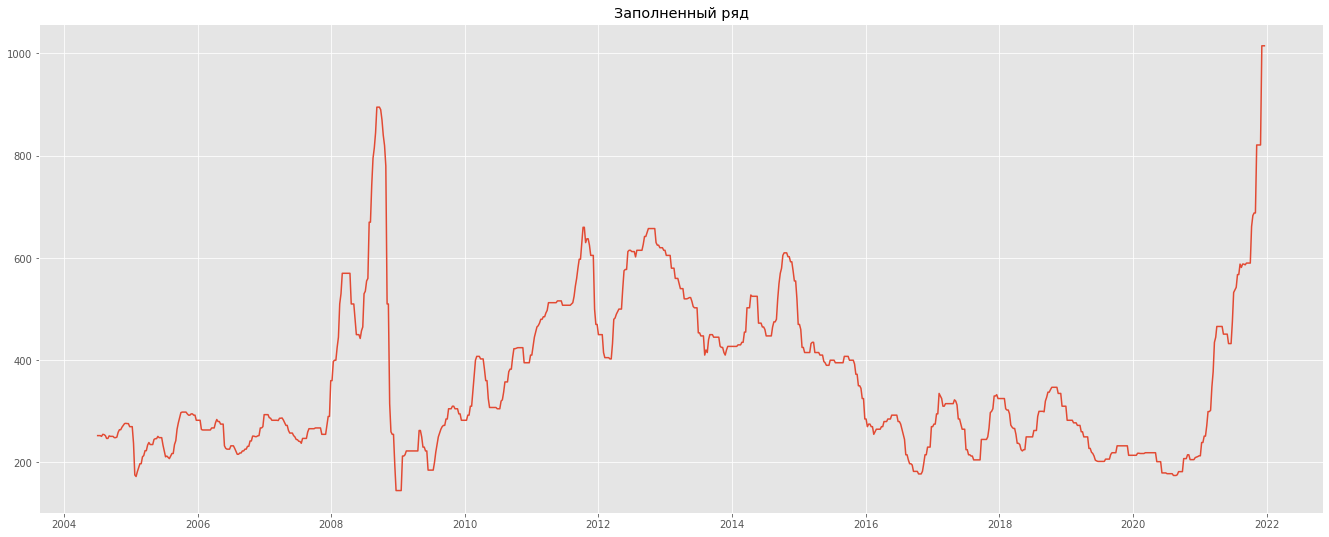

In [21]:

plt.plot(flat.ffill())
plt.title('Заполненный ряд');

#### Смотрим на структуру данных!

Любые паттерны данных и их структура могут помочь в заполнении пропусков. Во-первых, если в данных есть тренд.

In [22]:
import numpy as np

mask = np.random.binomial(1, 0.2, size=len(data)) > 0 
gdp_true = data.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

<AxesSubplot:>

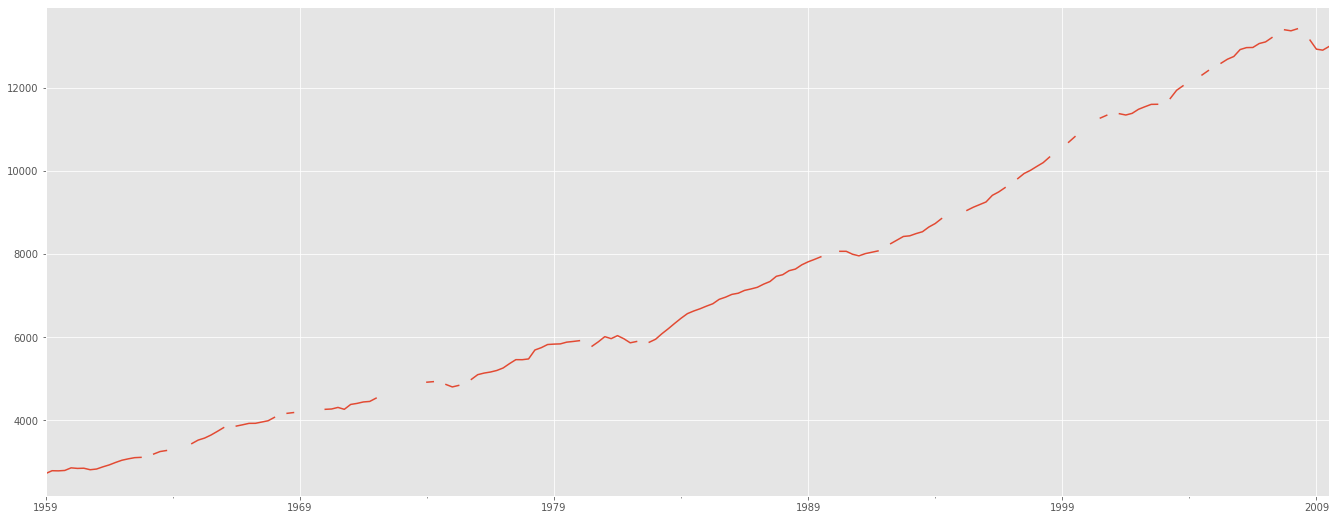

In [23]:
gdp_nan.plot()

<AxesSubplot:>

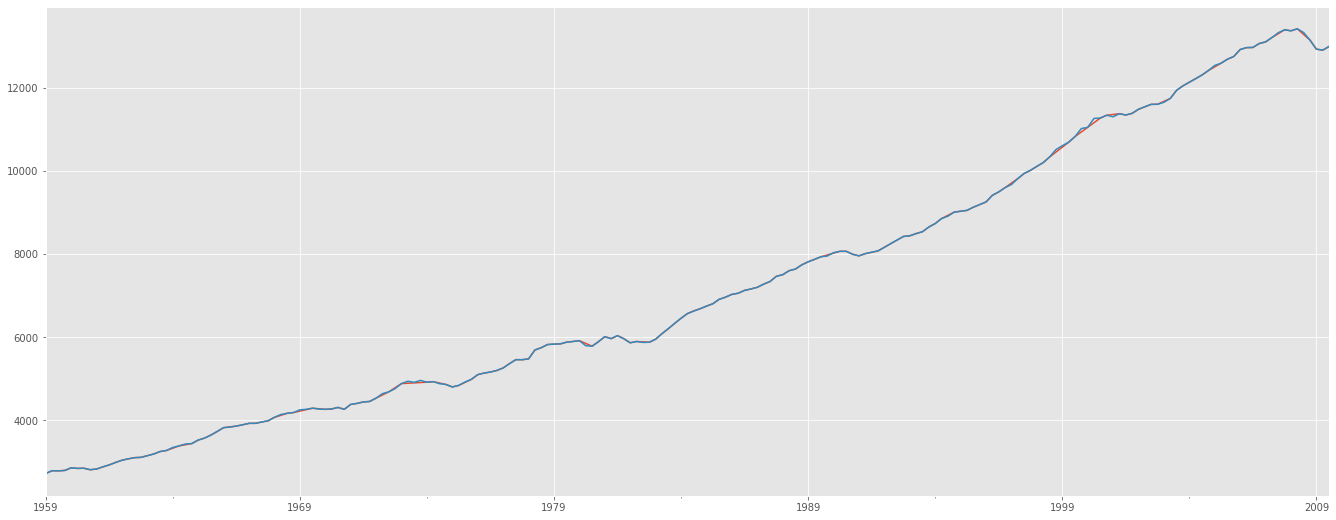

In [24]:
gdp_nan.interpolate(method='linear').plot()
gdp_true.plot()

<AxesSubplot:>

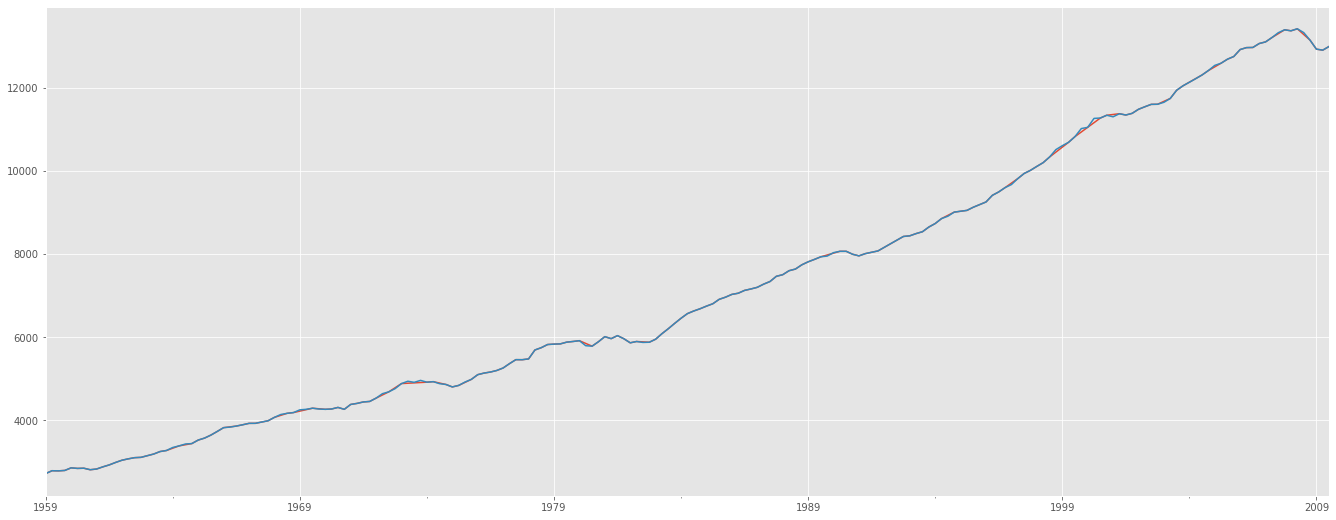

In [25]:
gdp_nan.interpolate(method='time').plot()
gdp_true.plot()

In [26]:
# MAE заполнения
np.abs(gdp_nan.interpolate(method='time') - gdp_true)[mask].mean()

27.499642194651308

## LOWESS

In [27]:
# mask = np.random.binomial(1, 0.1, size=len(data)) > 0 
gdp_true = data.realgdp.copy()
gdp_nan = gdp_true.copy()
gdp_nan[mask] = np.nan

gdp_nan = gdp_nan.reset_index(drop=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


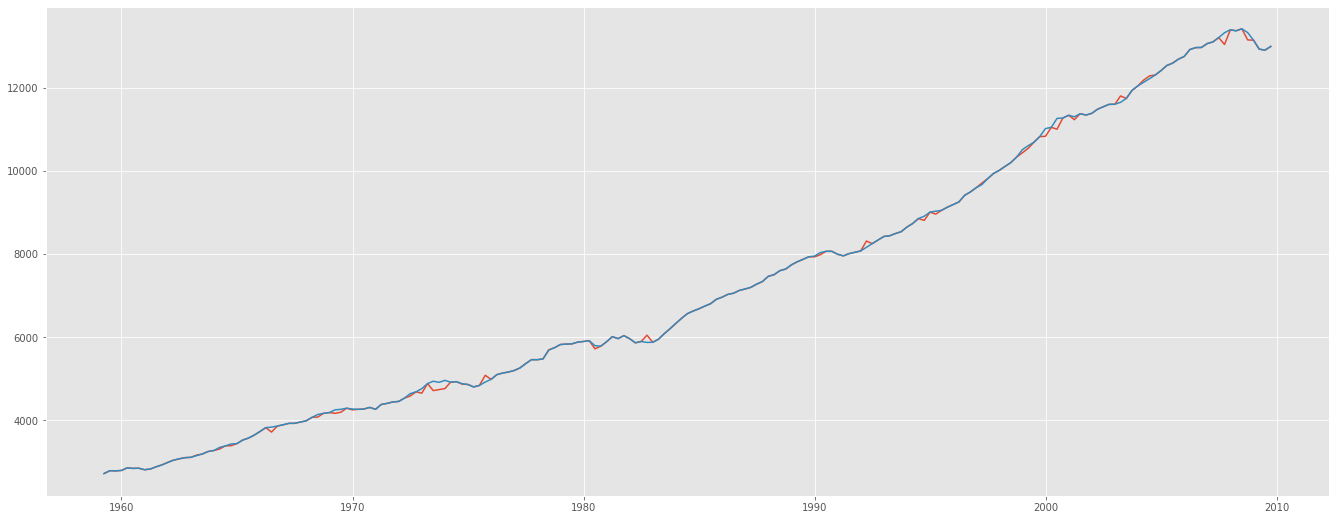

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from moepy import lowess

# Data generation
x = np.array(gdp_nan[~mask].index)
y = gdp_nan[~mask].values

x_pred = np.array(gdp_nan[mask].index)

# Model fitting
lowess_model = lowess.Lowess()
lowess_model.fit(x, y, frac=0.15)

# Model prediction
y_pred = lowess_model.predict(x_pred)
gdp_filled = gdp_nan.copy()
gdp_filled[mask] = y_pred
gdp_filled.index = gdp_true.index

# Plotting
plt.plot(gdp_filled)
plt.plot(gdp_true)
plt.legend(frameon=False)

In [35]:
# MAE заполнения
np.abs(gdp_filled - gdp_true)[mask].mean()

101.56670628116426

В случае, если данные носят сезонный характер, это тоже можно использовать. Например, заполнять последним доступным значением в аналогичном сезоне или усреднять по двум соседним аналогичным сезонам.

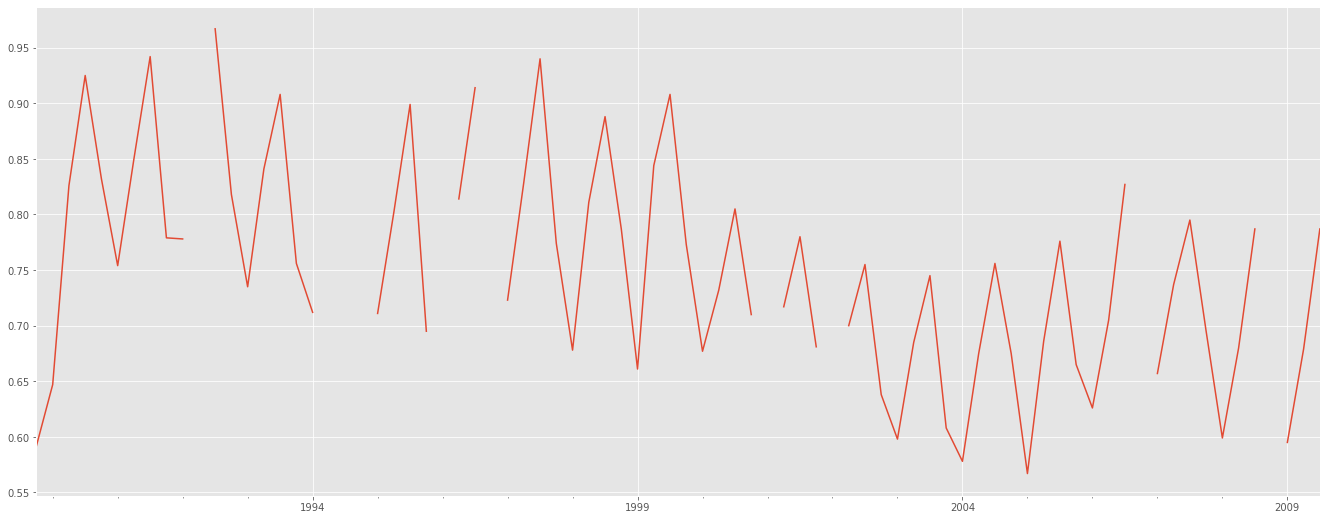

In [36]:
seasonal = data.loc[:,'pop'].diff().dropna().tail(80).copy()

mask = np.random.binomial(1, 0.1, size=len(seasonal)) > 0 

seasonal_nan = seasonal.copy()
seasonal_nan[mask] = np.nan
seasonal_nan.plot()

previous = seasonal.shift(4)
future = seasonal.shift(-4)


# Усредним предудыщий и следующий периоды в аналогичном сезоне
seasonal_nan[seasonal_nan.isna()] = ((previous + future) / 2)[seasonal_nan.isna()]

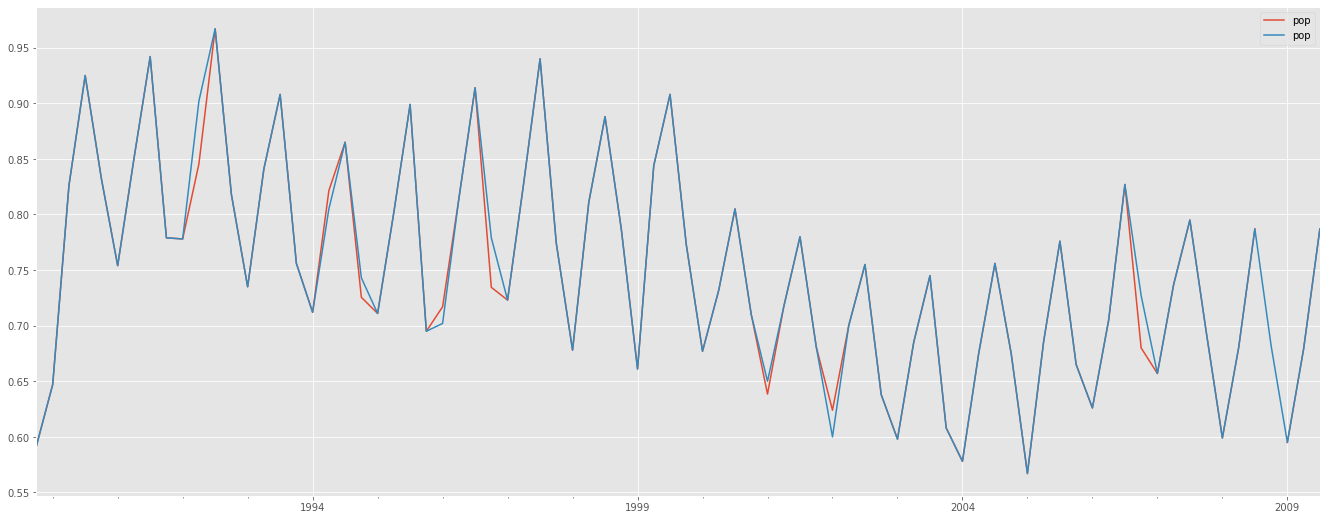

In [37]:
seasonal_nan.plot()
seasonal.plot()
plt.legend()

## Блок о том, почему наш курс не нужен

Первое о чём следует задуматься: а чем, собственно, ряды отличаются от стандартной задачи машинного обучений? Короткий ответ: особо ничем, но есть нюанс. В целом, задачу прогнозирования рядов можно решать как обычную табличную задачу. Сложность обычно в том, что под каждую задачу нужно отдельно возиться с генерацией признаков и порой простая модель временного ряда оказывается выразительнее кучи сгенерированныъ признаков. Сейчас мы попробуем повозиться немного с одной из таких задач. Данные взяты с [kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv). Будем прогнозировать потребление электроэнергии в Испании.

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_correlations
from sktime.forecasting.all import temporal_train_test_split
from sklearn.ensemble import RandomForestRegressor
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from catboost import  CatBoostRegressor

import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)



# Загрузим данные по энергетике
data = pd.read_csv('data/sem_2/energy_dataset.csv')

# # Преобразуем даты
data.index = pd.to_datetime(data.time.apply(lambda x: x.split('+')[0]))
data = data.drop(columns=['time'])


In [119]:
data

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
2018-12-31 20:00:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
2018-12-31 21:00:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30


In [120]:
# Загрузим данные по погоде
weather = pd.read_csv('data/sem_2/weather_features.csv')

# Преобразуем даты
weather.index = pd.to_datetime(weather.dt_iso.apply(lambda x: x.split('+')[0]))
weather = weather.drop(columns=['dt_iso'])

# Усредним по регионам
weather = weather.groupby('dt_iso').mean()
weather.index.name = 'time'

weather

data = data.merge(weather.loc[:, ['temp']], how='left', left_on='time', right_on='time')

In [121]:
data

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41,272.491463
2015-01-01 01:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92,272.512700
2015-01-01 02:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48,272.099137
2015-01-01 03:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32,272.089469
2015-01-01 04:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04,272.145900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02,284.470000
2018-12-31 20:00:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16,282.294000
2018-12-31 21:00:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30,280.850000


In [122]:
target = data.loc[:,'total load actual'].resample('D').sum()




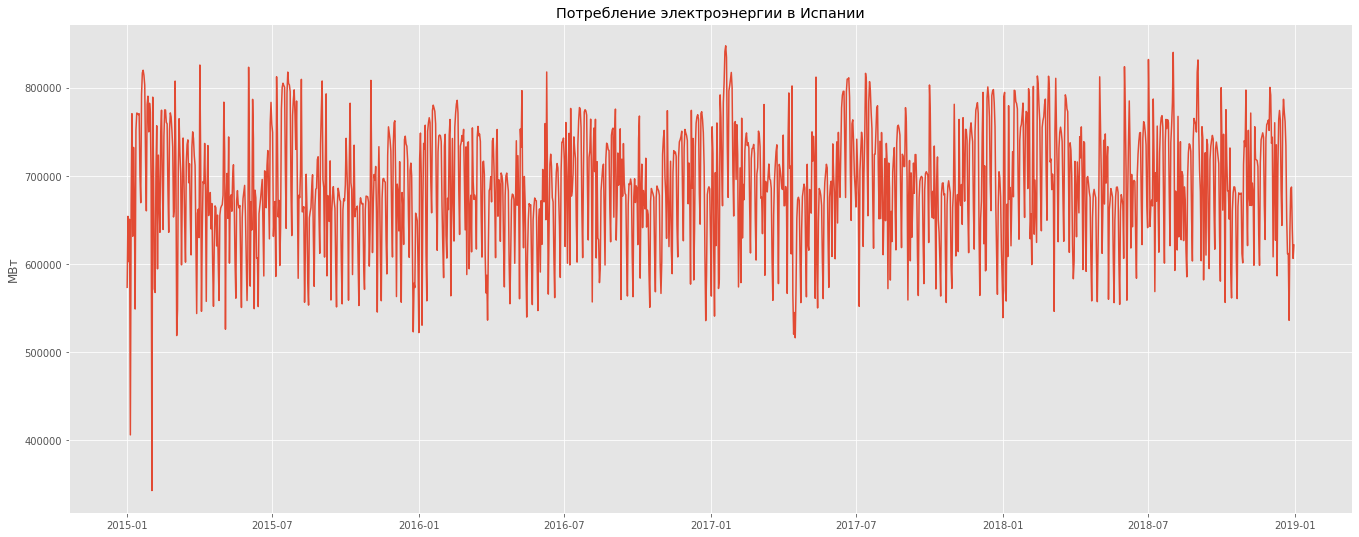

In [123]:
# Найти 
plt.plot(target)
plt.title('Потребление электроэнергии в Испании')
plt.ylabel('МВт');

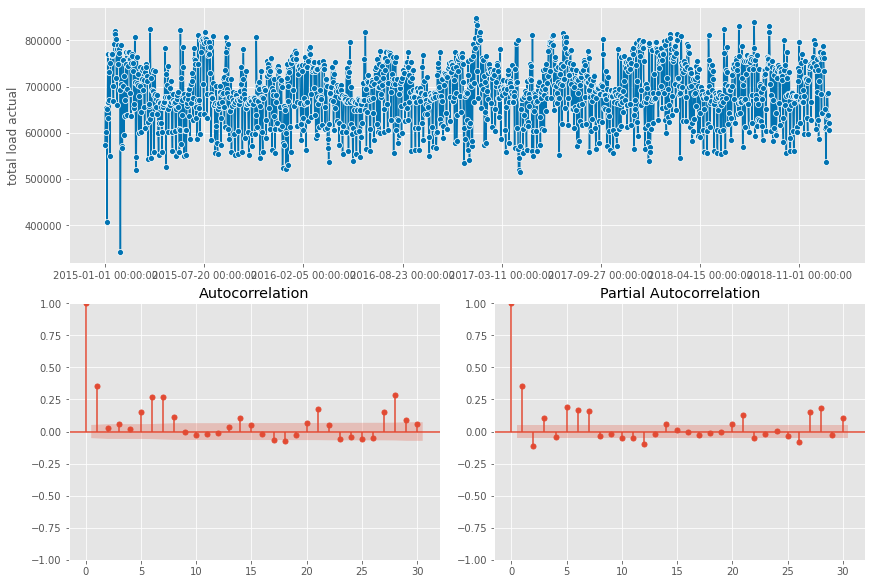

In [124]:
plot_correlations(target, lags=30);

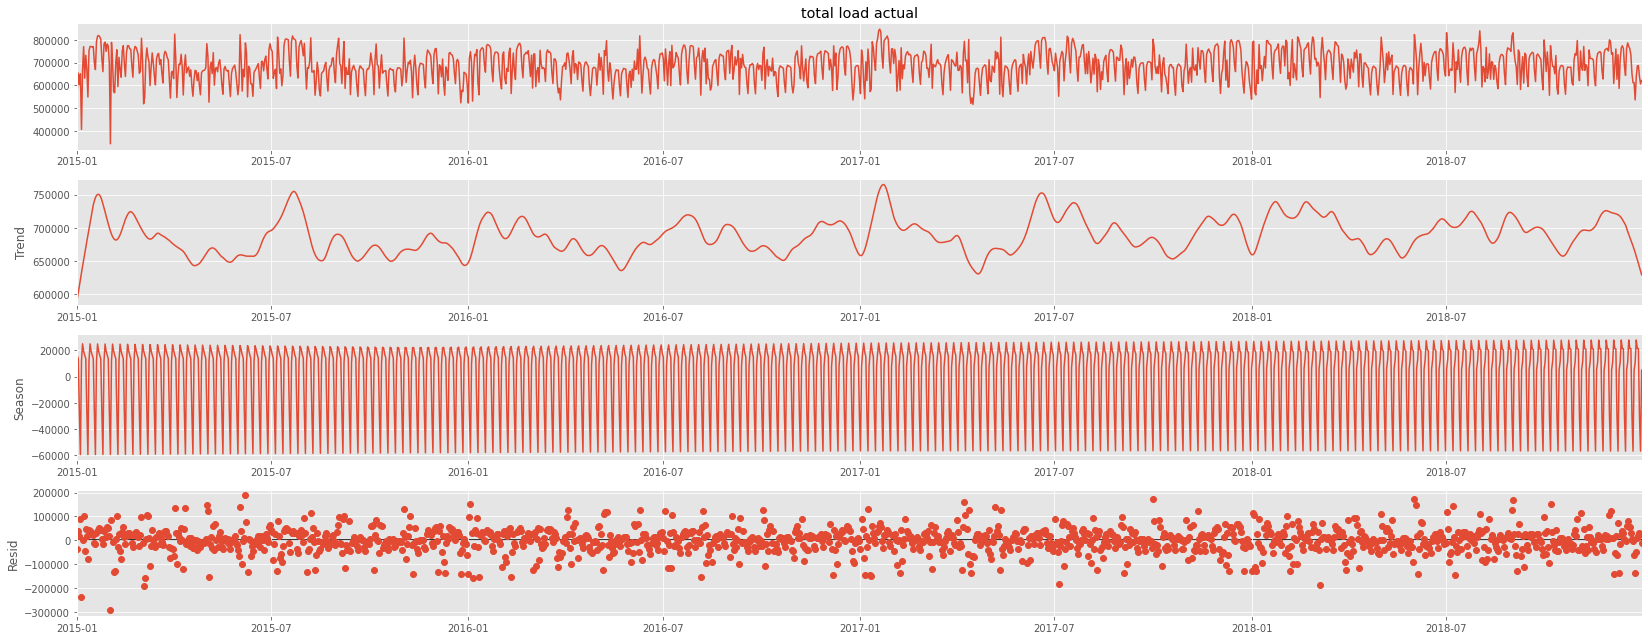

In [125]:
from statsmodels.tsa.seasonal import STL

stl = STL(target, seasonal=365, trend=31)
res = stl.fit()
res.plot();


In [126]:
import holidays

es_holidays = holidays.Spain()

X = pd.DataFrame()

WINDOW = 10

X['target'] = data.loc[:,'total load actual'].resample('D').sum()

X['y_L1'] = X['target'].shift(1)
X['y_L2'] = X['target'].shift(2)
X['y_L3'] = X['target'].shift(3)
X['y_L4'] = X['target'].shift(4)

X['y_L6'] = X['target'].shift(6)
X['y_L7'] = X['target'].shift(7)
X['y_L31'] = X['target'].shift(31)

# X['y_L364'] = X['target'].shift(364)
# X['y_L365'] = X['target'].shift(365)
# X['y_L366'] = X['target'].shift(366)


X['diff_L1'] = X['target'].diff().shift(1)

# X['rolling_mean'] = X['target'].rolling(WINDOW).mean().shift(1)


# X['month'] = X.index.month
X['day'] = X.index.day
X['weekday'] = X.index.weekday
X['is_weekend'] = X.index.weekday >= 5
X['season'] = X.index.month%12 // 3 + 1


X['temp'] = data.loc[:,'temp'].resample('D').min() * (X.season == 1) \
        + data.loc[:,'temp'].resample('D').max() * (X.season == 3) \
        + data.loc[:,'temp'].resample('D').mean() * ((X.season == 2) | (X.season == 4))

# X['temp'] = X['temp'].shift(365)

# X['cos'] = np.cos((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))
X['sin'] = np.sin((X.index - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s"))


X['is_holiday'] = X.index.to_series().apply(lambda x: x in es_holidays)

In [127]:
X = X.dropna()

y = X.target
X = X.drop(columns=['target', "season"])

In [128]:
X

,y_L1,y_L2,y_L3,y_L4,y_L6,y_L7,y_L31,diff_L1,day,weekday,is_weekend,temp,sin,is_holiday
time,,,,,,,,,,,,,,
2015-02-01,693434.0,772470.0,782389.0,749901.0,780961.0,660295.0,573522.0,-79036.0,1,6,True,277.211400,0.954748,False
2015-02-02,342907.0,693434.0,772470.0,782389.0,790396.0,780961.0,654031.0,-350527.0,2,0,False,275.896800,0.975717,False
2015-02-03,789294.0,342907.0,693434.0,772470.0,749901.0,790396.0,602656.0,446387.0,3,1,False,278.907463,0.990262,False
2015-02-04,705374.0,789294.0,342907.0,693434.0,782389.0,749901.0,650703.0,-83920.0,4,2,False,276.093469,0.998289,False
2015-02-05,571751.0,705374.0,789294.0,342907.0,772470.0,782389.0,406070.0,-133623.0,5,3,False,275.405600,0.999743,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,636691.0,536106.0,611884.0,611552.0,734264.0,761545.0,742193.0,100585.0,27,3,False,277.454000,-0.629956,False
2018-12-28,684773.0,636691.0,536106.0,611884.0,651730.0,734264.0,758041.0,48082.0,28,4,False,277.512000,-0.690844,False
2018-12-29,687306.0,684773.0,636691.0,536106.0,611552.0,651730.0,760195.0,2533.0,29,5,True,277.722000,-0.747183,False


In [129]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

scaler = MinMaxScaler()
cat_features = [
    # 'month',
    'day',
    'weekday',
    'is_weekend',
    'is_holiday',
    # 'season'
    ]

num_features = [col for col in X_train.columns if col not in cat_features]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [105]:


model = CatBoostRegressor(iterations=50, 
                          depth=2, 
                          learning_rate=0.5)

model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
y_pred = pd.Series(model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)


0.05429281145026304

In [104]:
dict(zip(X.columns, model.feature_importances_))

{'y_L1': 25.281413857788714,
 'y_L2': 1.3448929731394468,
 'y_L3': 2.425119475597013,
 'y_L4': 4.100371049592578,
 'y_L6': 7.489595309281147,
 'y_L7': 0.7363440542382302,
 'y_L31': 3.595673903778162,
 'diff_L1': 12.575975045472878,
 'day': 7.485517730776213,
 'weekday': 0.5607905293306212,
 'is_weekend': 26.548850743907824,
 'temp': 4.501937373038929,
 'sin': 1.289325298575137,
 'is_holiday': 2.064192655483086}

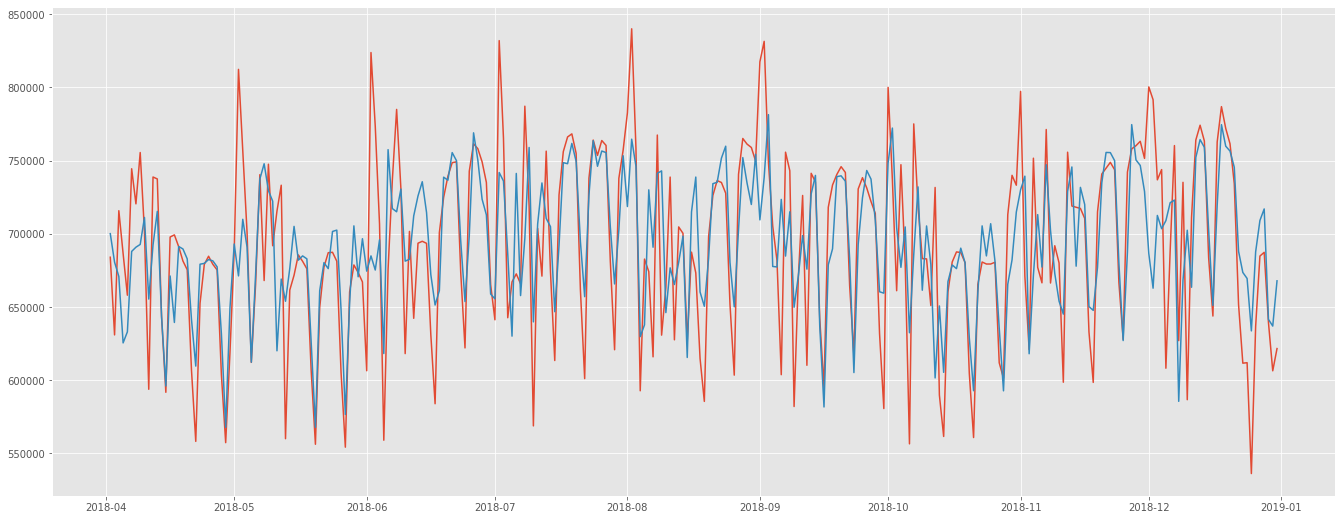

In [88]:
plt.plot(y.tail(len(y_pred)))
plt.plot(y_pred)

In [112]:
mean_absolute_percentage_error(y_test, y_pred)

mean_absolute_percentage_error(y_test, y.tail(len(y_pred)).shift(1).fillna(0))

# np.mean(np.abs((y_pred - y.tail(len(y_pred)))) / y.tail(len(y_pred)))

0.0843078360662755

## Стратегии многошагового прогнозирования

В предыдущем пункте, казалось бы, всё было хорошо. Мы научились прогнозировать с некоторой относительно неплохой точностью временной ряд. Однако есть одна загвоздка. Мы научились прогнозировать только на один шаг. А хотелось бы, конечно, на много шагов. Именно многошаговое прогнозирование является основной задачей при работе с временными рядами (хотя, конечно, и не всегда). 

Для построения многошаговых прогнозов необходима, как и в одношаговом случае, оценить некоторую модель, а потом с помощью специальной методики (стратегии) применить её для прогнозирования. Мы рассмотрим две основные существующие стратегии: рекурсивная (recursive) и прямая (direct).

## Рекурсивная стратегия

Давайте представим, что нам необходимо спрогнозировать какой-то временной ряд на 5 шагов вперёд. Точку, из которой мы строим прогноз, обычно называют forecast origin, а то, на сколько шагов мы прогнозируем -- горизонт прогнозирования (forecast horizon). Пусть также у нас предполагается самая простая модель:

$$ y_t = \beta_0 + \beta_1 y_{t-1}+ \epsilon_t$$

Как только мы найдём любым доступным способом $\hat{\beta}_0 $ и $\hat{\beta}_1$, то сможем построить прогноз на один шаг вперёд:

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t}$$

На один шаг мы построили. Теперь давайте подумаем про второй. Хотелось бы, конечно, построить следующее уравнение:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 y_{t+1}$$

Однако $y_{t+1}$ мы не знаем. Однако знаем оценку, $\hat{y}_{t+1}$. Ну значит давайте и подставим её, чтобы всё работало. Таким образом прогноз на два шага будет основываться на прогнозе на один шаг:

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1}$$

Эту стратегию использую чаще всего. Более того, большая часть статистических моделей, которые мы будем проходить впоследствии, просто технически не могут реализовать какую-то другую. Однако она не лишена недостатков. Один из основных -- накопление ошибки при рекурсивных прогнозах. С каждым шагом ошибка предыдущего шага порождает ещё большу ошибку на последующих. Особенно сильно такой эффект наблюдается, когда модель имеет авторегрессию большего порядка. Значит, что в каждом последующем прогнозе будет учитываться оценка не только предыдущего момента времени, но и оценки всех значений, входящих в уравнение. Например:

$$ \hat{y}_{t+3} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+2} + \hat{\beta}_2 \hat{y}_{t+1} + \hat{\beta}_2 y_{t}$$

Помимо этого существует ещё одна существенная проблема. Давайте снова представим простую модель, но уже с экзогенной переменной $x_t$:

$$ y_t = \beta_0 + \beta_1 y_{t-1} + \gamma_1 x_{t-1} \epsilon_t$$

$$ \hat{y}_{t+1} = \hat{\beta}_0 + \hat{\beta}_1 y_{t} + + \hat{\gamma}_1 x_{t} $$

При одношаговом прогнозе в целом никаких проблем не возникает. Однако на втором шаге уже проблемы: 

$$ \hat{y}_{t+2} = \hat{\beta}_0 + \hat{\beta}_1 \hat{y}_{t+1} + \hat{\gamma}_1 x_{t+1} $$

$x_{t+1}$ нам взять неоткуда. Следовательно, у нас два варианта. Либо прогнозировать отдельно ряд $x_t$, что добавит ещё больше шума в модель, либо не использовать этот регрессор вообще и полагаться только на фичи, которые либо основаны на $y_t$ (тоже добавит шума), либо могут быть сгенерированы независимо (например, календарные фичи). На самом деле часто бывают задачи, в которых экзогенных переменных нет вовсе и такая проблема не стоит, но всё же это достаточно редкий случай. 

Наши данные из-за большого количества экзогенных и производных переменных не подойдут под рекурсивную стратегию, поэтому приведём здесь пример на более игрушечных данных.

In [113]:
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import make_reduction

# imports necessary for this chapter
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sklearn.linear_model import LinearRegression

# data loading for illustration (see section 1 for explanation)
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=40)
fh = ForecastingHorizon(y_test.index, is_relative=False)

0.15450840467307853

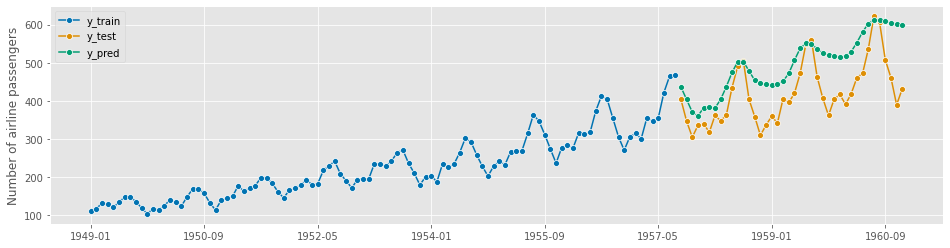

In [116]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=10, strategy="recursive")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## Прямая стратегия

Внимательный слушатель резонно задастся вопросом: А зачем, собственно, предсказывать все горизонты одной моделью. И правда, да ничего не мешает. Пусть нам нужно прогнозировать на h шагов. Тогда оценим h моделей вида:

$$ \hat{y}_{t+1} = \hat{\beta}_0^1 + \hat{\beta}_1^1 y_{t}$$

$$ \hat{y}_{t+2} = \hat{\beta}_0^2 + \hat{\beta}_1^2 y_{t}$$

$$ \hat{y}_{t+3} = \hat{\beta}_0^3 + \hat{\beta}_1^3 y_{t}$$

$$ \cdots $$

$$ \hat{y}_{t+k} = \hat{\beta}_0^k + \hat{\beta}_1^k y_{t}$$

Недостатки такого подхода:
* Вместо одной модели нужно оценивать h. Это очень сильно увеличивает вычислительные затраты, особенно при кросс-валидации.
* Растёт общий разброс модели, так как оцениваем в h раз больше параметров.

Преимущества такого подхода:
* Очевидно, меньше смещение. Ошибки предыдущих горизонтов не влияют на проноз по текущему.
* Более явная модель для многошагового прогноза. Можно, например, подобрать одни переменные, важные для прогноза на длинный период и друге для короткого. 
* Обычно высокий разброс не так критичен как смещение рекурсивной стратегии и в моей практике я стараюсь использовать прямую стратегию.
* Никаких проблем с экзогенными и производными переменными.
* Часто очень неплохо работает вкупе с обычной линейной регрессией и при грамотно сгенерированных фичах

0.04061570008131543

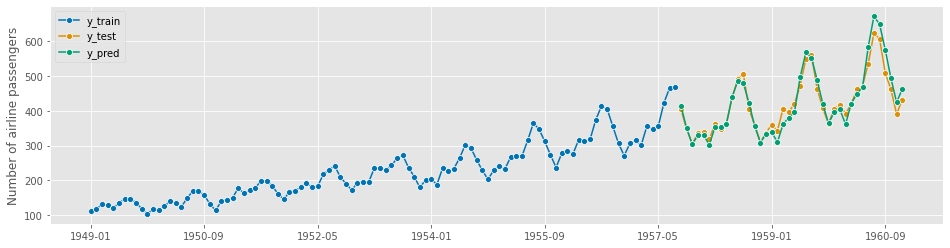

In [117]:
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=10, strategy="direct")

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:611: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:83: Fut

0.0646802788959758

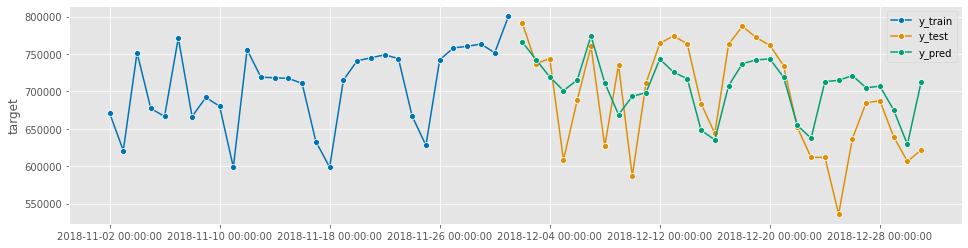

In [130]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=30)

scaler = MinMaxScaler()
cat_features = [
    # 'month',
    'day',
    'weekday',
    'is_weekend',
    'is_holiday',
    # 'season'
    ]
num_features = [col for col in X_train.columns if col not in cat_features]

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

fh = ForecastingHorizon(y_test.index, is_relative=False)

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=20, strategy="direct")

forecaster.fit(y_train, X=X_train, fh=fh);
y_pred = forecaster.predict()
plot_series(y_train.tail(30), y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## Бенчмарки

In [131]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# step 1: splitting historical data
# y = load_airline()
# y_train, y_test = temporal_train_test_split(y, test_size=36)

# step 2: running the basic forecasting workflow
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

# step 3: specifying the evaluation metric
mape = MeanAbsolutePercentageError(symmetric=False)
# if function interface is used, just use the function directly in step 4

# step 4: computing the forecast performance
mape(y_test, y_pred)

# step 5: testing forecast performance against baseline
# under development

C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:601: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\forecasting\base\_fh.py:611: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:81: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
C:\Users\zehov\Desktop\current_projects\envs\ts\lib\site-packages\sktime\utils\datetime.py:83: Fut

0.11524182452059722